# This notebook uses pytorch lightning & optuna & a Recurrent Attentive Neural Process for Sequential Data (RANPfSQ)

This notebook trains an Attentional Neural Network on timeseries data from smartmeters.

It uses pytorch lighting for the training loop. And Optuna for the hyperparameter optimisation.

It also pushes results to the tensorboard hyperparameter dashboard for examination.

- https://github.com/optuna/optuna/blob/master/examples/pytorch_lightning_simple.py

- similar to https://arxiv.org/abs/1910.09323

Results on *Smartmeter* prediction

|Model|val_loss|
|--|--| 
|ANP-RNN|-1.27|
|ANP-RNN_imp|-1.38|
|ANP|-1.3|
|ANP_impr|-1.2|
|NP|-1.3|

In [1]:
import sys, re, os, itertools, functools, collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
from pathlib import Path
from tqdm.auto import tqdm

import optuna
import pytorch_lightning as pl
from optuna.integration import PyTorchLightningPruningCallback


import math
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import torch.nn.functional as F

In [3]:

from neural_processes.data.smart_meter import collate_fns, SmartMeterDataSet, get_smartmeter_df
from neural_processes.plot import plot_from_loader

from neural_processes.dict_logger import DictLogger
from neural_processes.utils import PyTorchLightningPruningCallback
from neural_processes.train import main, objective, add_number, run_trial

from neural_processes.models.neural_process import PL_NeuralProcess

from neural_processes.models.transformer import PL_Transformer
from neural_processes.models.transformer_seq2seq import TransformerSeq2Seq_PL

from neural_processes.models.lstm_seqseq import LSTMSeq2Seq_PL
from neural_processes.models.lstm_std import LSTM_PL_STD

/home/wassname/.pyenv/versions/jup3.7.3/lib/python3.7/site-packages/pytorch_lightning/core/decorators.py:13: UserWarning:

data_loader decorator deprecated in 0.7.0. Will remove 0.9.0



In [4]:
# Params
device='cuda'
use_logy=False

In [5]:
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger("RANP.ipynb")

# Load kaggle smart meter data

In [6]:
df_train, df_val, df_test = get_smartmeter_df()

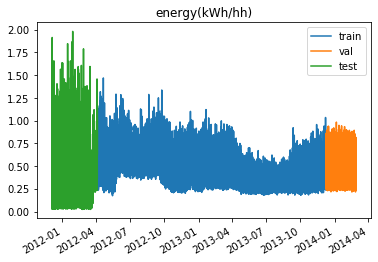

In [7]:
# Show split
df_train['energy(kWh/hh)'].plot(label='train')
df_val['energy(kWh/hh)'].plot(label='val')
df_test['energy(kWh/hh)'].plot(label='test')
plt.title('energy(kWh/hh)')
plt.legend()

# Default params

In [8]:
default_user_attrs = {
    'context_in_target': False,
    'x_dim': 17,
    'y_dim': 1,
    'vis_i': '670',
    'num_workers': 3,
    'num_context': 24*4,
    'num_extra_target': 24*4,
    'max_nb_epochs': 200,
    'min_std': 0.005,
    'grad_clip': 40,
    'batch_size': 16,
    'patience': 2
}

In [9]:
results = {}

# Models

## ANP-RNN

now run `tensorboard --logdir lightning_logs`
trial -44 <optuna.trial.FixedTrial object at 0x7f3ef4065be0> {'learning_rate': 0.002, 'attention_layers': 2, 'num_heads_power': 3, 'hidden_dim_power': 7, 'latent_dim_power': 7, 'n_latent_encoder_layers': 2, 'n_det_encoder_layers': 4, 'n_decoder_layers': 4, 'dropout': 0, 'attention_dropout': 0, 'latent_enc_self_attn_type': 'uniform', 'det_enc_self_attn_type': 'uniform', 'det_enc_cross_attn_type': 'multihead', 'batchnorm': False, 'use_self_attn': True, 'use_lvar': False, 'use_deterministic_path': True, 'use_rnn': True} {'batch_size': 16, 'grad_clip': 40, 'max_nb_epochs': 200, 'num_workers': 3, 'num_context': 96, 'vis_i': '670', 'num_extra_target': 96, 'x_dim': 17, 'context_in_target': False, 'y_dim': 1, 'patience': 2, 'min_std': 0.005}
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
Loading checkpoint lightning_logs/anp-rnn/version_-44/_ckpt_epoch_1.ckpt


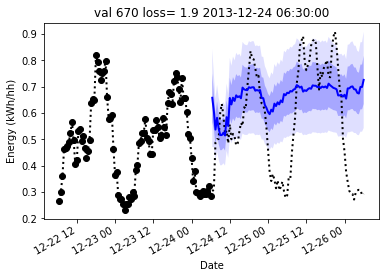

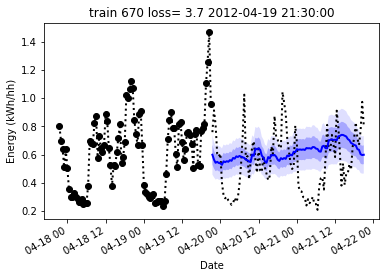

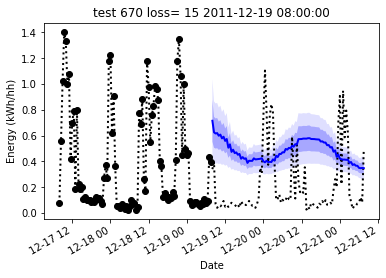

INFO:predict_heading2:step 0, {'test_loss': '14.489921569824219', 'test_loss_p': '14.476164817810059', 'test_loss_kl': '0.013756104744970798', 'test_loss_mse': '0.2005576640367508'}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



In [10]:
trial, trainer, model = run_trial(
    name="anp-rnn",
    params={
     'det_enc_cross_attn_type': 'multihead',
     'det_enc_self_attn_type': 'uniform',
     'latent_enc_self_attn_type': 'uniform',
     'use_deterministic_path': True,
     'use_rnn': True,
     'use_lvar': False,
    },
    user_attrs = default_user_attrs,
    PL_MODEL_CLS=PL_NeuralProcess,
    number=-44
)

In [11]:
name = trainer.logger.name
results[f"{name}_{trial.number}"]=dict(
    **trainer.logger.metrics[-1],
    **(trainer.logger.metrics[-2] if len(trainer.logger.metrics)>1 else {})
)
results[f"{name}_{trial.number}"]

{'test_loss': 14.489921569824219,
 'test_loss_p': 14.476164817810059,
 'test_loss_kl': 0.013756104744970798,
 'test_loss_mse': 0.2005576640367508}

## ANP-RNN 2

now run `tensorboard --logdir lightning_logs`
trial.number -8
trial -8 <optuna.trial.FixedTrial object at 0x7f3ef3bc60f0> {'learning_rate': 0.002, 'attention_layers': 2, 'num_heads_power': 3, 'hidden_dim_power': 7, 'latent_dim_power': 7, 'n_latent_encoder_layers': 2, 'n_det_encoder_layers': 4, 'n_decoder_layers': 4, 'dropout': 0, 'attention_dropout': 0, 'latent_enc_self_attn_type': 'multihead', 'det_enc_self_attn_type': 'multihead', 'det_enc_cross_attn_type': 'multihead', 'batchnorm': False, 'use_self_attn': True, 'use_lvar': False, 'use_deterministic_path': False, 'use_rnn': True} {'batch_size': 16, 'grad_clip': 40, 'max_nb_epochs': 200, 'num_workers': 3, 'num_context': 96, 'vis_i': '670', 'num_extra_target': 96, 'x_dim': 17, 'context_in_target': False, 'y_dim': 1, 'patience': 2, 'min_std': 0.005}
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
    | Name                                                                       | Type                 | Param

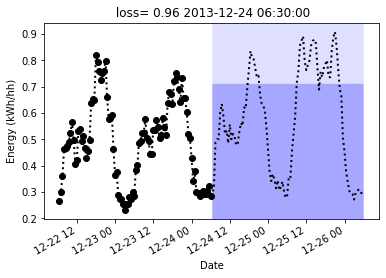

step 0, {'val_loss': '0.8739740252494812', 'val/loss_mse': '0.29288801550865173', 'val/loss_p': '0.8739740252494812', 'val/sigma': '1.0551170110702515'}


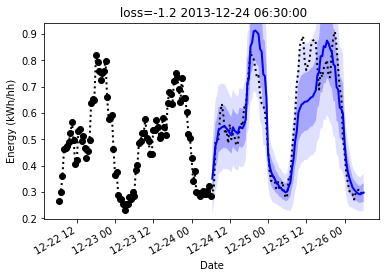

step 1826, {'val_loss': '-1.4538644552230835', 'val/loss_mse': '0.004145827144384384', 'val/loss_p': '-1.4538644552230835', 'val/sigma': '0.0666576698422432'}


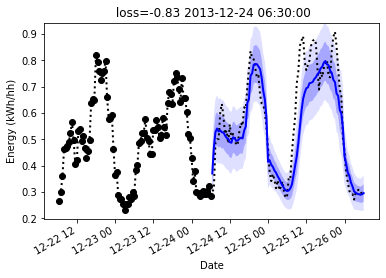

step 3653, {'val_loss': '-1.4794896841049194', 'val/loss_mse': '0.0038728932850062847', 'val/loss_p': '-1.4794896841049194', 'val/sigma': '0.05024576187133789'}


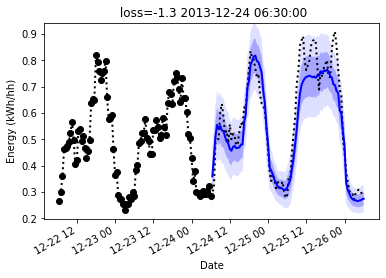

step 5480, {'val_loss': '-1.4645498991012573', 'val/loss_mse': '0.0036937142722308636', 'val/loss_p': '-1.4645498991012573', 'val/sigma': '0.04625311866402626'}


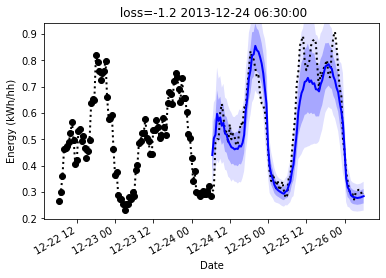

step 7307, {'val_loss': '-1.339970350265503', 'val/loss_mse': '0.004385458305478096', 'val/loss_p': '-1.339970350265503', 'val/sigma': '0.05185338482260704'}


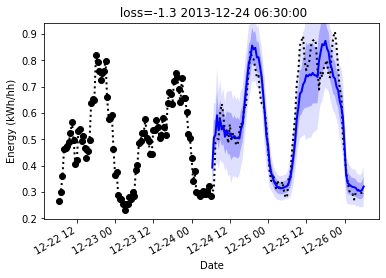

step 9134, {'val_loss': '-1.380592703819275', 'val/loss_mse': '0.00383735541254282', 'val/loss_p': '-1.380592703819275', 'val/sigma': '0.04510224238038063'}
Epoch     4: reducing learning rate of group 0 to 2.0000e-04.


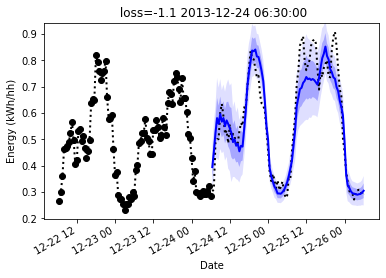

step 10961, {'val_loss': '-1.2441567182540894', 'val/loss_mse': '0.003684310708194971', 'val/loss_p': '-1.2441567182540894', 'val/sigma': '0.035968467593193054'}
INFO:root:Epoch 00006: early stopping



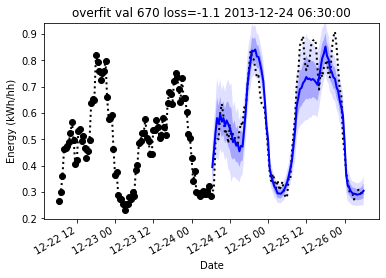

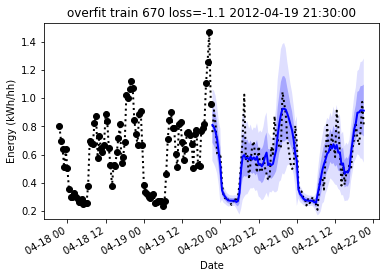

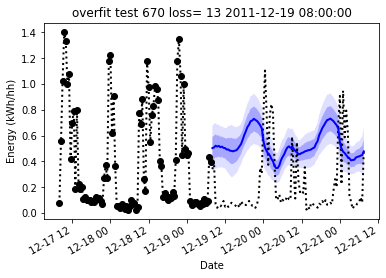

Loading checkpoint lightning_logs/anp-rnn2/version_-8/_ckpt_epoch_1.ckpt


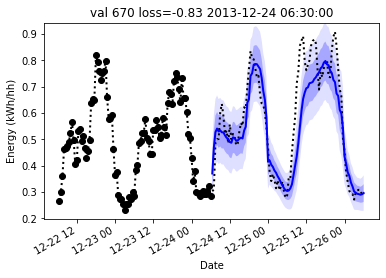

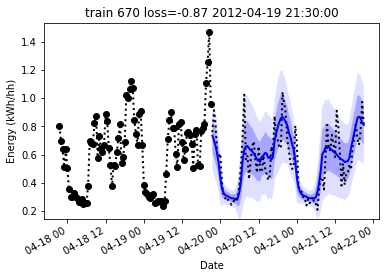

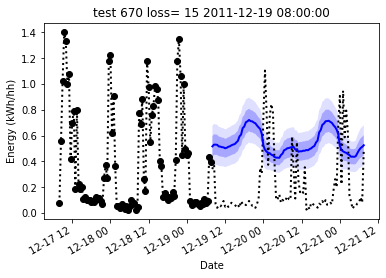

INFO:predict_heading2:step 10962, {'test_loss': '9.16368579864502', 'test_loss_p': '9.13418960571289', 'test_loss_kl': '0.02949560433626175', 'test_loss_mse': '0.14720813930034637'}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



In [12]:
trial, trainer, model = run_trial(
    name="anp-rnn2",
    params={ 
        'det_enc_self_attn_type': 'multihead',
        'latent_enc_self_attn_type': 'multihead',
        'use_deterministic_path': False,
        'use_rnn': True,
        'use_lvar': False,
    },
    user_attrs=default_user_attrs,
    PL_MODEL_CLS=PL_NeuralProcess)

In [13]:
name = trainer.logger.name
results[f"{name}_{trial.number}"]=dict(
    **trainer.logger.metrics[-1],
    **(trainer.logger.metrics[-2] if len(trainer.logger.metrics)>1 else {})
)
results[f"{name}_{trial.number}"]

{'test_loss': 9.16368579864502,
 'test_loss_p': 9.13418960571289,
 'test_loss_kl': 0.02949560433626175,
 'test_loss_mse': 0.14720813930034637,
 'val_loss': -1.2441567182540894,
 'val/loss_mse': 0.003684310708194971,
 'val/loss_p': -1.2441567182540894,
 'val/sigma': 0.035968467593193054}

## ANP

now run `tensorboard --logdir lightning_logs`
trial.number -5
trial -5 <optuna.trial.FixedTrial object at 0x7f3ef3bc62b0> {'learning_rate': 0.002, 'attention_layers': 2, 'num_heads_power': 3, 'hidden_dim_power': 7, 'latent_dim_power': 7, 'n_latent_encoder_layers': 2, 'n_det_encoder_layers': 4, 'n_decoder_layers': 4, 'dropout': 0, 'attention_dropout': 0, 'latent_enc_self_attn_type': 'multihead', 'det_enc_self_attn_type': 'multihead', 'det_enc_cross_attn_type': 'multihead', 'batchnorm': False, 'use_self_attn': True, 'use_lvar': False, 'use_deterministic_path': False, 'use_rnn': False} {'batch_size': 16, 'grad_clip': 40, 'max_nb_epochs': 200, 'num_workers': 3, 'num_context': 96, 'vis_i': '670', 'num_extra_target': 96, 'x_dim': 17, 'context_in_target': False, 'y_dim': 1, 'patience': 2, 'min_std': 0.005}
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
    | Name                                                                       | Type                 | Para

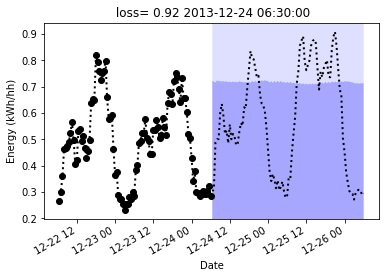

step 0, {'val_loss': '0.8324257135391235', 'val/loss_mse': '0.26696568727493286', 'val/loss_p': '0.8324257135391235', 'val/sigma': '1.0047248601913452'}


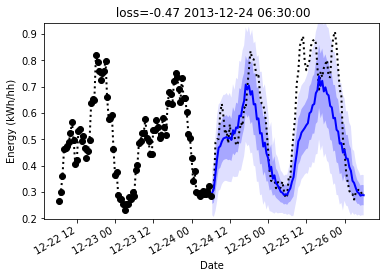

step 1826, {'val_loss': '-1.1794251203536987', 'val/loss_mse': '0.007557246834039688', 'val/loss_p': '-1.1794251203536987', 'val/sigma': '0.0768723338842392'}


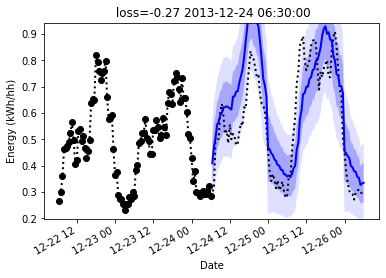

step 3653, {'val_loss': '-1.2176175117492676', 'val/loss_mse': '0.005573200527578592', 'val/loss_p': '-1.2176175117492676', 'val/sigma': '0.07973399758338928'}


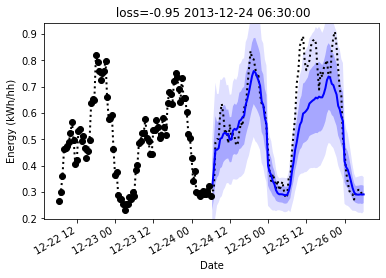

step 5480, {'val_loss': '-1.1941940784454346', 'val/loss_mse': '0.007381444331258535', 'val/loss_p': '-1.1941940784454346', 'val/sigma': '0.08087006956338882'}


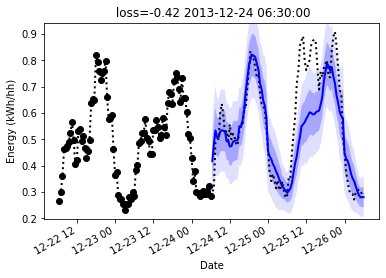

step 7307, {'val_loss': '-1.3168423175811768', 'val/loss_mse': '0.004908399656414986', 'val/loss_p': '-1.3168423175811768', 'val/sigma': '0.07081601768732071'}


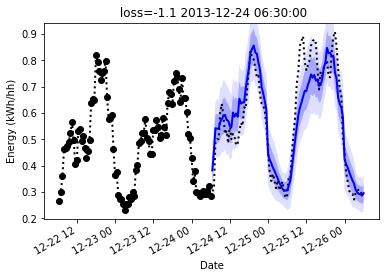

step 9134, {'val_loss': '-1.3116459846496582', 'val/loss_mse': '0.004547908436506987', 'val/loss_p': '-1.3116459846496582', 'val/sigma': '0.04911728575825691'}


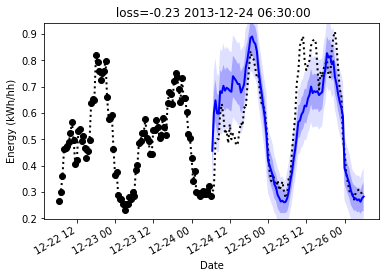

step 10961, {'val_loss': '-1.2213026285171509', 'val/loss_mse': '0.005644602235406637', 'val/loss_p': '-1.2213026285171509', 'val/sigma': '0.056611888110637665'}


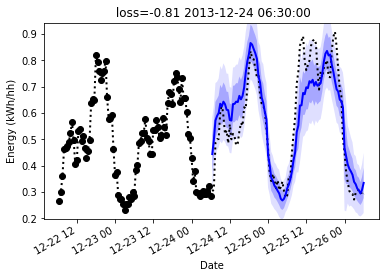

step 12788, {'val_loss': '-1.4108154773712158', 'val/loss_mse': '0.004188407212495804', 'val/loss_p': '-1.4108154773712158', 'val/sigma': '0.05021091550588608'}


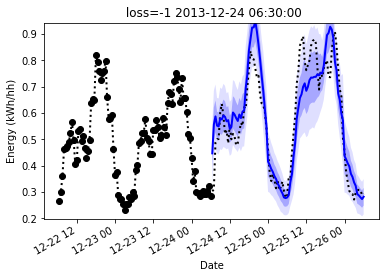

step 14615, {'val_loss': '-1.2996526956558228', 'val/loss_mse': '0.004909162875264883', 'val/loss_p': '-1.2996526956558228', 'val/sigma': '0.05542095750570297'}


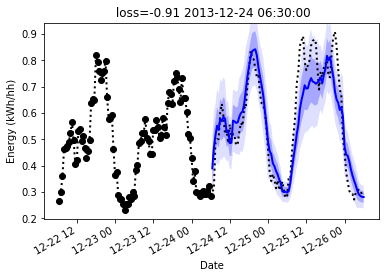

step 16442, {'val_loss': '-1.154371738433838', 'val/loss_mse': '0.00515166437253356', 'val/loss_p': '-1.154371738433838', 'val/sigma': '0.05301789566874504'}


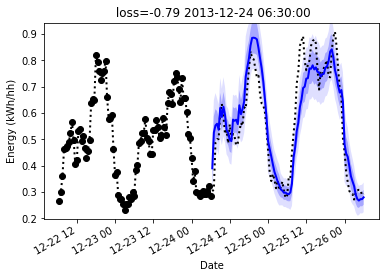

step 18269, {'val_loss': '-1.2089158296585083', 'val/loss_mse': '0.004578482825309038', 'val/loss_p': '-1.2089158296585083', 'val/sigma': '0.04453665018081665'}
Epoch     9: reducing learning rate of group 0 to 2.0000e-04.


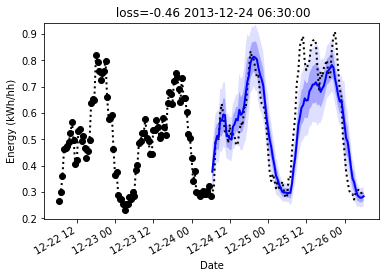

step 20096, {'val_loss': '-1.1541602611541748', 'val/loss_mse': '0.004413253162056208', 'val/loss_p': '-1.1541602611541748', 'val/sigma': '0.04288777709007263'}
INFO:root:Epoch 00011: early stopping



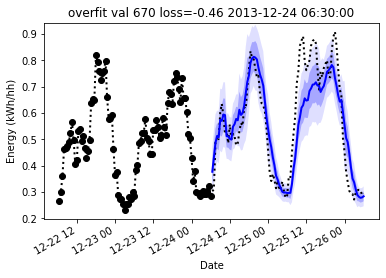

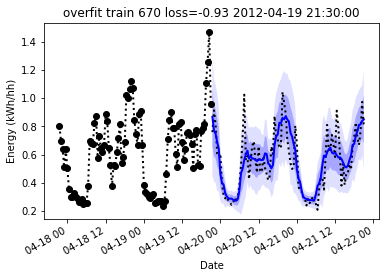

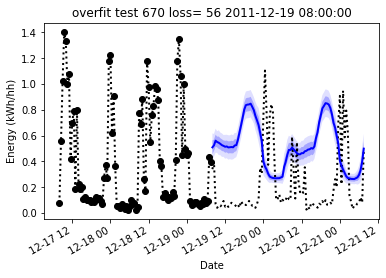

Loading checkpoint lightning_logs/anp_c/version_-5/_ckpt_epoch_6.ckpt


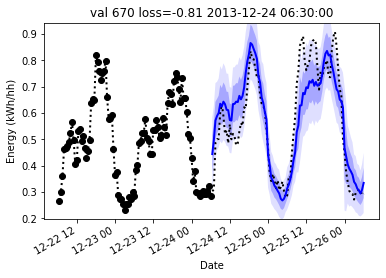

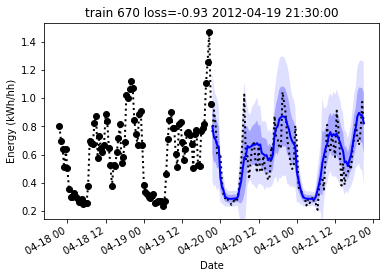

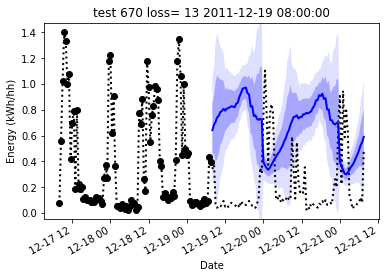

INFO:predict_heading2:step 20097, {'test_loss': '9.58957290649414', 'test_loss_p': '9.308001518249512', 'test_loss_kl': '0.2815711796283722', 'test_loss_mse': '0.27289435267448425'}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



In [14]:
trial, trainer, model = run_trial(name="anp_c",
                                  params={
                                      'det_enc_cross_attn_type': 'multihead',
                                      'det_enc_self_attn_type': 'multihead',
                                      'latent_enc_self_attn_type': 'multihead',
                                      'use_deterministic_path': False,
                                      'use_lvar': False,
                                  },
                                  user_attrs=default_user_attrs,
                                  PL_MODEL_CLS=PL_NeuralProcess)

In [15]:
name = trainer.logger.name
results[f"{name}_{trial.number}"]=dict(
    **trainer.logger.metrics[-1],
    **(trainer.logger.metrics[-2] if len(trainer.logger.metrics)>1 else {})
)
results[f"{name}_{trial.number}"]

{'test_loss': 9.58957290649414,
 'test_loss_p': 9.308001518249512,
 'test_loss_kl': 0.2815711796283722,
 'test_loss_mse': 0.27289435267448425,
 'val_loss': -1.1541602611541748,
 'val/loss_mse': 0.004413253162056208,
 'val/loss_p': -1.1541602611541748,
 'val/sigma': 0.04288777709007263}

## NP

now run `tensorboard --logdir lightning_logs`
trial.number -4
trial -4 <optuna.trial.FixedTrial object at 0x7f3ee86b42e8> {'learning_rate': 0.002, 'attention_layers': 2, 'num_heads_power': 3, 'hidden_dim_power': 7, 'latent_dim_power': 7, 'n_latent_encoder_layers': 2, 'n_det_encoder_layers': 4, 'n_decoder_layers': 4, 'dropout': 0, 'attention_dropout': 0, 'latent_enc_self_attn_type': 'uniform', 'det_enc_self_attn_type': 'uniform', 'det_enc_cross_attn_type': 'uniform', 'batchnorm': False, 'use_self_attn': True, 'use_lvar': False, 'use_deterministic_path': False, 'use_rnn': False} {'batch_size': 16, 'grad_clip': 40, 'max_nb_epochs': 200, 'num_workers': 3, 'num_context': 96, 'vis_i': '670', 'num_extra_target': 96, 'x_dim': 17, 'context_in_target': False, 'y_dim': 1, 'patience': 2, 'min_std': 0.005}
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
   | Name                                                                       | Type                 | Params
----

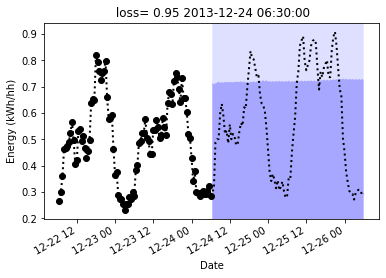

step 0, {'val_loss': '0.855606198310852', 'val/loss_mse': '0.2757818102836609', 'val/loss_p': '0.855606198310852', 'val/sigma': '1.0484498739242554'}


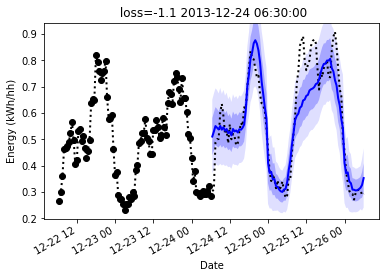

step 1826, {'val_loss': '-1.4352227449417114', 'val/loss_mse': '0.0040225675329566', 'val/loss_p': '-1.4352227449417114', 'val/sigma': '0.05855812132358551'}


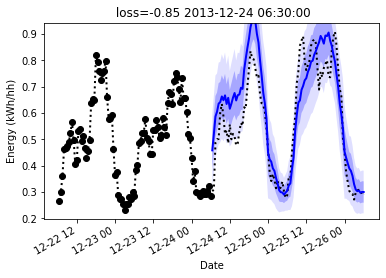

step 3653, {'val_loss': '-1.4200385808944702', 'val/loss_mse': '0.0038046627305448055', 'val/loss_p': '-1.4200385808944702', 'val/sigma': '0.05061909556388855'}


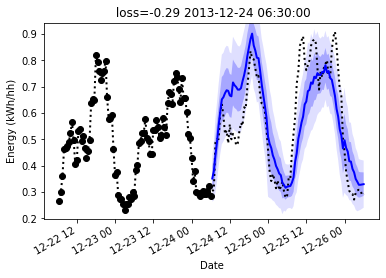

step 5480, {'val_loss': '-1.4078880548477173', 'val/loss_mse': '0.003992301411926746', 'val/loss_p': '-1.4078880548477173', 'val/sigma': '0.05551478639245033'}


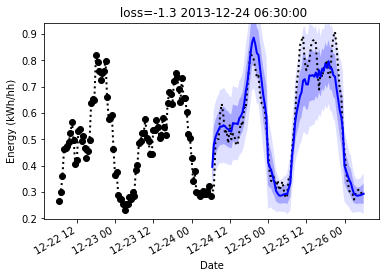

step 7307, {'val_loss': '-1.4591007232666016', 'val/loss_mse': '0.003550340188667178', 'val/loss_p': '-1.4591007232666016', 'val/sigma': '0.05422995984554291'}


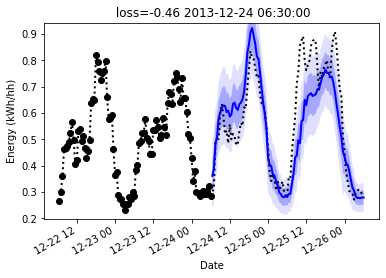

step 9134, {'val_loss': '-1.3980361223220825', 'val/loss_mse': '0.004368913825601339', 'val/loss_p': '-1.3980361223220825', 'val/sigma': '0.04945729300379753'}


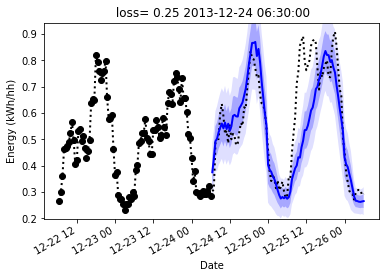

step 10961, {'val_loss': '-1.0711027383804321', 'val/loss_mse': '0.005775631871074438', 'val/loss_p': '-1.0711027383804321', 'val/sigma': '0.04833202064037323'}


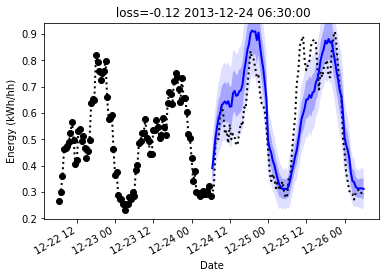

step 12788, {'val_loss': '-1.3496793508529663', 'val/loss_mse': '0.00435338681563735', 'val/loss_p': '-1.3496793508529663', 'val/sigma': '0.0502760075032711'}
Epoch     6: reducing learning rate of group 0 to 2.0000e-04.


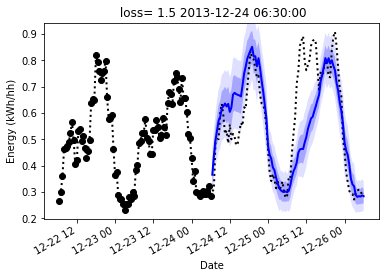

step 14615, {'val_loss': '-1.0682815313339233', 'val/loss_mse': '0.004987745545804501', 'val/loss_p': '-1.0682815313339233', 'val/sigma': '0.04170318692922592'}
INFO:root:Epoch 00008: early stopping



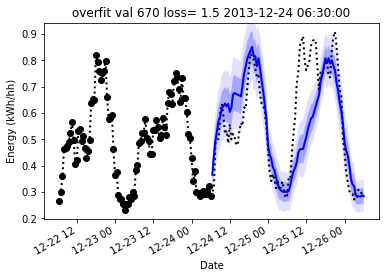

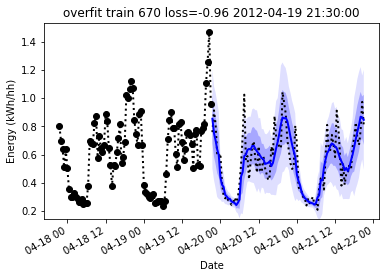

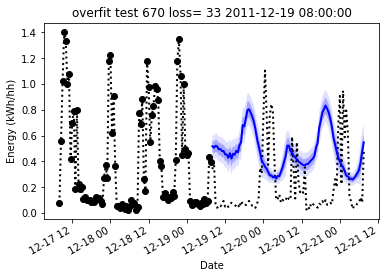

Loading checkpoint lightning_logs/np/version_-4/_ckpt_epoch_3.ckpt


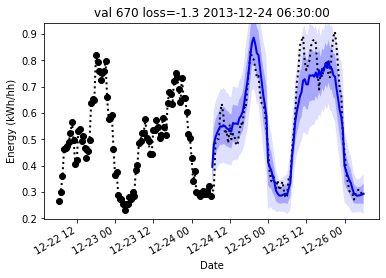

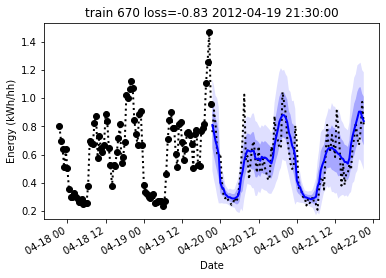

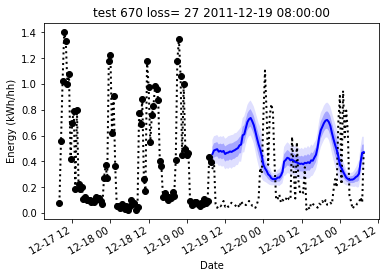

INFO:predict_heading2:step 14616, {'test_loss': '11.587808609008789', 'test_loss_p': '11.568707466125488', 'test_loss_kl': '0.019099321216344833', 'test_loss_mse': '0.1160716563463211'}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



In [16]:
trial, trainer, model = run_trial(name="np",
                                  params={
                                      'det_enc_cross_attn_type': 'uniform',
                                      'det_enc_self_attn_type': 'uniform',
                                      'latent_enc_self_attn_type': 'uniform',
                                      'use_deterministic_path': False,
                                      'use_lvar': False,
                                  },
                                  user_attrs=default_user_attrs,
                                  PL_MODEL_CLS=PL_NeuralProcess)

In [17]:
name = trainer.logger.name
results[f"{name}_{trial.number}"]=dict(
    **trainer.logger.metrics[-1],
    **(trainer.logger.metrics[-2] if len(trainer.logger.metrics)>1 else {})
)
results[f"{name}_{trial.number}"]

{'test_loss': 11.587808609008789,
 'test_loss_p': 11.568707466125488,
 'test_loss_kl': 0.019099321216344833,
 'test_loss_mse': 0.1160716563463211,
 'val_loss': -1.0682815313339233,
 'val/loss_mse': 0.004987745545804501,
 'val/loss_p': -1.0682815313339233,
 'val/sigma': 0.04170318692922592}

## Transformer

In [18]:
trial, trainer, model = run_trial(name="PL_Transformer",
                                  params={
                                  },
                                  user_attrs={**default_user_attrs, 'context_in_target': False},
                                  PL_MODEL_CLS=PL_Transformer, number=-21)

now run `tensorboard --logdir lightning_logs`
trial -21 <optuna.trial.FixedTrial object at 0x7f3ee86de320> {'learning_rate': 0.003, 'attention_dropout': 0.4, 'hidden_size_power': 7.0, 'hidden_out_size_power': 7.0, 'nhead_power': 1.0, 'nlayers': 2} {'batch_size': 16, 'grad_clip': 40, 'max_nb_epochs': 200, 'num_workers': 3, 'vis_i': '670', 'x_dim': 17, 'y_dim': 1, 'context_in_target': False, 'patience': 2, 'min_std': 0.005, 'nan_value': -99.9, 'num_context': 96, 'num_extra_target': 96}
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0


INFO:predict_heading2:step 0, {'test_loss_p': '0.1652086228132248', 'test_loss_mse': '0.2676282227039337'}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



In [19]:
# %debug

In [20]:
name = trainer.logger.name
results[f"{name}_{trial.number}"]=dict(
    **trainer.logger.metrics[-1],
    **(trainer.logger.metrics[-2] if len(trainer.logger.metrics)>1 else {})
)
results[f"{name}_{trial.number}"]

{'test_loss_p': 0.1652086228132248, 'test_loss_mse': 0.2676282227039337}

## Transformer Seq2Seq

now run `tensorboard --logdir lightning_logs`
trial.number -7
trial -7 <optuna.trial.FixedTrial object at 0x7f3ee86152e8> {'learning_rate': 0.0023, 'attention_dropout': 0.12, 'hidden_size_power': 7, 'hidden_out_size_power': 4, 'nhead_power': 2, 'nlayers': 4} {'batch_size': 16, 'grad_clip': 40, 'max_nb_epochs': 200, 'num_workers': 3, 'num_extra_target': 96, 'vis_i': '670', 'num_context': 96, 'input_size': 18, 'input_size_decoder': 17, 'context_in_target': False, 'output_size': 1, 'patience': 2, 'min_std': 0.005, 'x_dim': 17, 'y_dim': 1}
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
    | Name                                            | Type                    | Params
----------------------------------------------------------------------------------------
0   | _model                                          | TransformerSeq2SeqNet   | 48 K  
1   | _model.enc_norm                                 | BatchNormSequence       | 36    
2   | _model.enc_norm.n

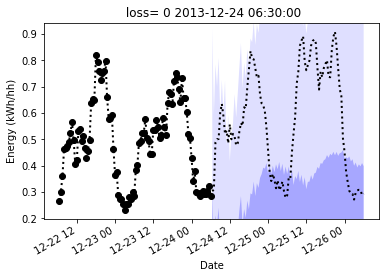

step 0, {'val_loss': '0.5734018087387085', 'val/loss_mse': '1.3506519794464111', 'val/loss_p': '0.5734018087387085', 'val/sigma': '0.6446830630302429'}


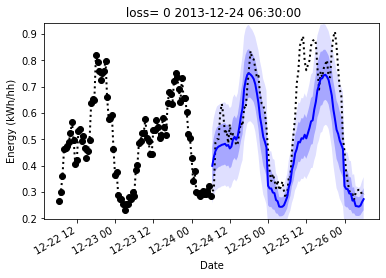

step 1826, {'val_loss': '-0.23509718477725983', 'val/loss_mse': '0.006281457841396332', 'val/loss_p': '-0.23509718477725983', 'val/sigma': '0.07667277008295059'}


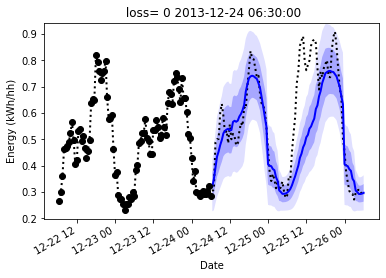

step 3653, {'val_loss': '-0.23244218528270721', 'val/loss_mse': '0.005470867268741131', 'val/loss_p': '-0.23244218528270721', 'val/sigma': '0.07078564167022705'}


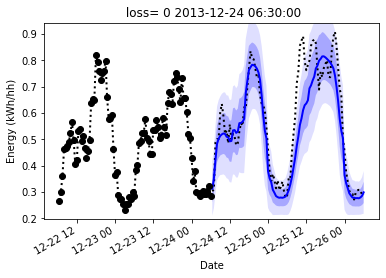

step 5480, {'val_loss': '-0.270678848028183', 'val/loss_mse': '0.004225695505738258', 'val/loss_p': '-0.270678848028183', 'val/sigma': '0.06625878065824509'}


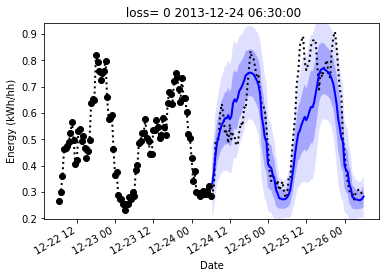

step 7307, {'val_loss': '-0.2563704252243042', 'val/loss_mse': '0.004548665136098862', 'val/loss_p': '-0.2563704252243042', 'val/sigma': '0.07887402176856995'}


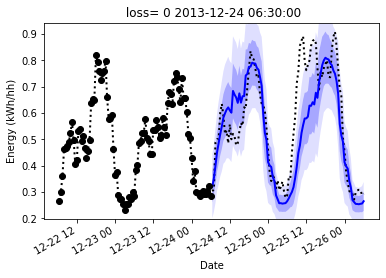

step 9134, {'val_loss': '-0.2597983479499817', 'val/loss_mse': '0.004673127084970474', 'val/loss_p': '-0.2597983479499817', 'val/sigma': '0.07003838568925858'}


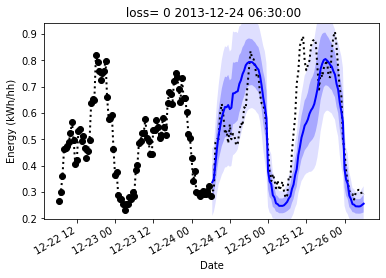

step 10961, {'val_loss': '-0.25576603412628174', 'val/loss_mse': '0.004202697891741991', 'val/loss_p': '-0.25576603412628174', 'val/sigma': '0.07318932563066483'}
Epoch     5: reducing learning rate of group 0 to 2.3000e-04.


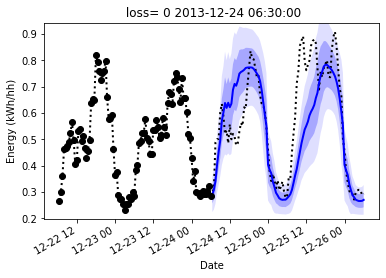

step 12788, {'val_loss': '-0.274300754070282', 'val/loss_mse': '0.0041540395468473434', 'val/loss_p': '-0.274300754070282', 'val/sigma': '0.06252964586019516'}


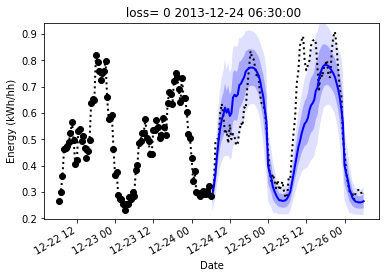

step 14615, {'val_loss': '-0.2798902094364166', 'val/loss_mse': '0.0037904258351773024', 'val/loss_p': '-0.2798902094364166', 'val/sigma': '0.062388449907302856'}


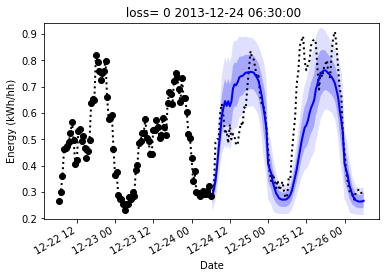

step 16442, {'val_loss': '-0.275814414024353', 'val/loss_mse': '0.004033994860947132', 'val/loss_p': '-0.275814414024353', 'val/sigma': '0.05803877115249634'}


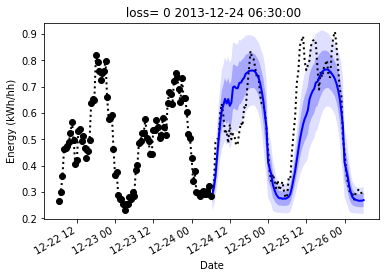

step 18269, {'val_loss': '-0.28100255131721497', 'val/loss_mse': '0.003980089444667101', 'val/loss_p': '-0.28100255131721497', 'val/sigma': '0.05903400480747223'}


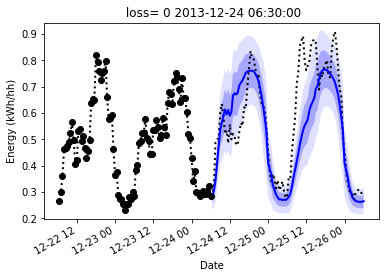

step 20096, {'val_loss': '-0.2798205018043518', 'val/loss_mse': '0.003898449707776308', 'val/loss_p': '-0.2798205018043518', 'val/sigma': '0.059353772550821304'}


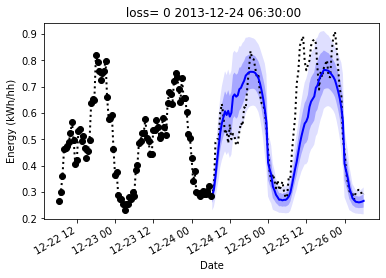

step 21923, {'val_loss': '-0.2788048982620239', 'val/loss_mse': '0.0039538550190627575', 'val/loss_p': '-0.2788048982620239', 'val/sigma': '0.05614820495247841'}


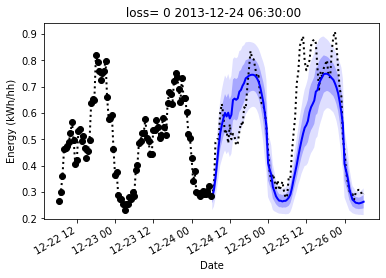

step 23750, {'val_loss': '-0.2734948694705963', 'val/loss_mse': '0.004071784671396017', 'val/loss_p': '-0.2734948694705963', 'val/sigma': '0.05648357793688774'}
Epoch    12: reducing learning rate of group 0 to 2.3000e-05.


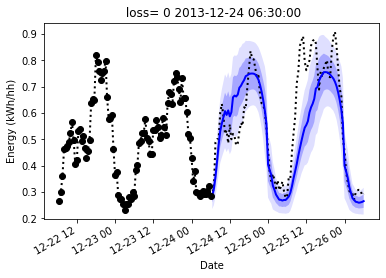

step 25577, {'val_loss': '-0.2753245532512665', 'val/loss_mse': '0.004053365904837847', 'val/loss_p': '-0.2753245532512665', 'val/sigma': '0.05592680722475052'}
INFO:root:Epoch 00014: early stopping



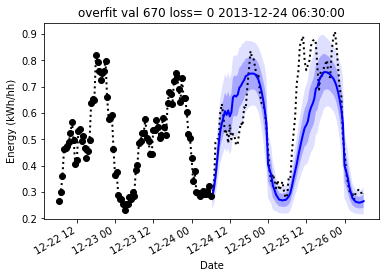

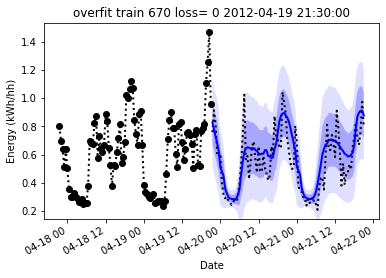

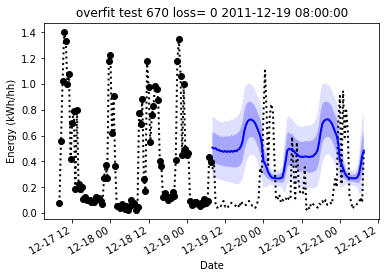

Loading checkpoint lightning_logs/TransformerSeq2Seq_PL/version_-7/_ckpt_epoch_9.ckpt


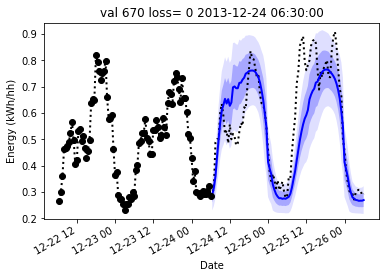

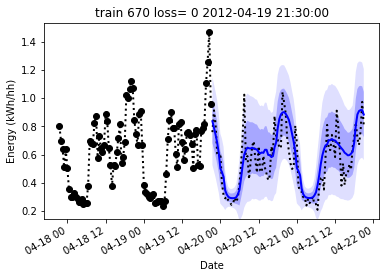

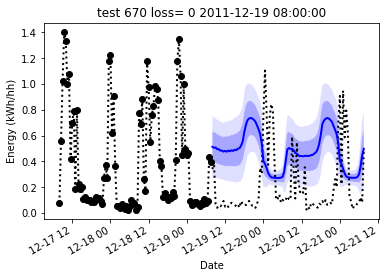

INFO:predict_heading2:step 25578, {'test_loss_p': '1.6251381635665894', 'test_loss_mse': '0.14620119333267212'}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



In [21]:
trial, trainer, model = run_trial(name="TransformerSeq2Seq_PL",
                                  params={},
                                  user_attrs=default_user_attrs,
                                  PL_MODEL_CLS=TransformerSeq2Seq_PL)

In [22]:
name = trainer.logger.name
results[f"{name}_{trial.number}"]=dict(
    **trainer.logger.metrics[-1],
    **(trainer.logger.metrics[-2] if len(trainer.logger.metrics)>1 else {})
)
results[f"{name}_{trial.number}"]

{'test_loss_p': 1.6251381635665894,
 'test_loss_mse': 0.14620119333267212,
 'val_loss': -0.2753245532512665,
 'val/loss_mse': 0.004053365904837847,
 'val/loss_p': -0.2753245532512665,
 'val/sigma': 0.05592680722475052}

## LSTM

now run `tensorboard --logdir lightning_logs`
trial.number -11
trial -11 <optuna.trial.FixedTrial object at 0x7f3ef4d19240> {'learning_rate': 0.001, 'lstm_dropout': 0.39, 'hidden_size_power': 5, 'lstm_layers': 4, 'bidirectional': False} {'batch_size': 16, 'grad_clip': 40, 'max_nb_epochs': 200, 'num_workers': 3, 'vis_i': '670', 'x_dim': 17, 'y_dim': 1, 'context_in_target': False, 'patience': 2, 'min_std': 0.005, 'nan_value': -99.9, 'num_context': 96, 'num_extra_target': 96}
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
  | Name         | Type    | Params
-------------------------------------
0 | _model       | LSTMNet | 32 K  
1 | _model.lstm1 | LSTM    | 32 K  
2 | _model.mean  | Linear  | 33    
3 | _model.std   | Linear  | 33    


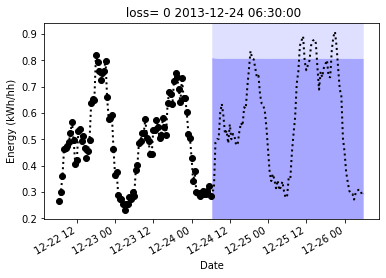

step 0, {'val_loss': '0.16640837490558624', 'val/loss_mse': '0.251861572265625', 'val/loss_p': '0.16640837490558624', 'val/sigma': '1.145904779434204'}


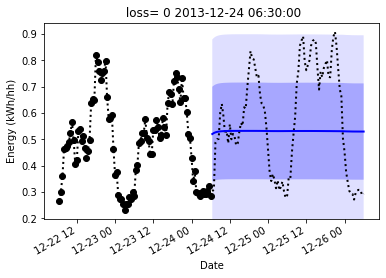

step 1826, {'val_loss': '-0.051183588802814484', 'val/loss_mse': '0.0336773581802845', 'val/loss_p': '-0.051183588802814484', 'val/sigma': '0.1470634490251541'}


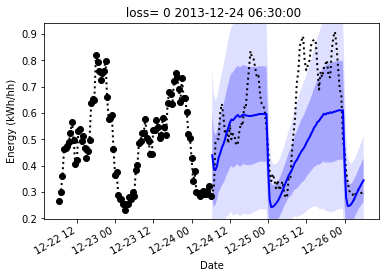

step 3653, {'val_loss': '-0.13804882764816284', 'val/loss_mse': '0.013707000762224197', 'val/loss_p': '-0.13804882764816284', 'val/sigma': '0.10516189783811569'}


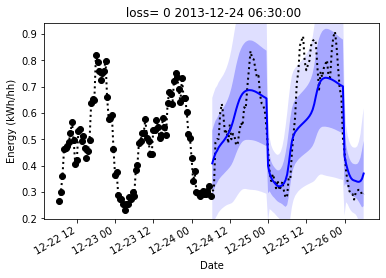

step 5480, {'val_loss': '-0.1489678919315338', 'val/loss_mse': '0.012532935477793217', 'val/loss_p': '-0.1489678919315338', 'val/sigma': '0.09823761880397797'}


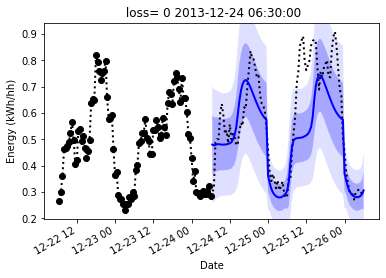

step 7307, {'val_loss': '-0.18721792101860046', 'val/loss_mse': '0.010066233575344086', 'val/loss_p': '-0.18721792101860046', 'val/sigma': '0.0659332200884819'}


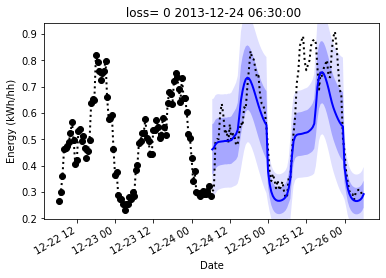

step 9134, {'val_loss': '-0.2117469757795334', 'val/loss_mse': '0.007664274889975786', 'val/loss_p': '-0.2117469757795334', 'val/sigma': '0.052034929394721985'}


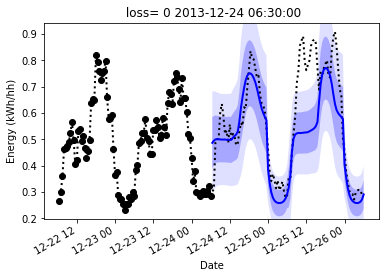

step 10961, {'val_loss': '-0.20723246037960052', 'val/loss_mse': '0.008008896373212337', 'val/loss_p': '-0.20723246037960052', 'val/sigma': '0.0573190338909626'}


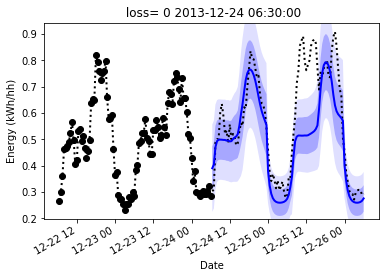

step 12788, {'val_loss': '-0.22388331592082977', 'val/loss_mse': '0.006247800774872303', 'val/loss_p': '-0.22388331592082977', 'val/sigma': '0.03954705968499184'}


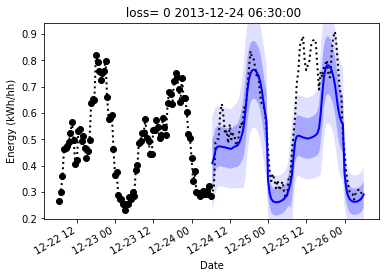

step 14615, {'val_loss': '-0.21313564479351044', 'val/loss_mse': '0.006697138771414757', 'val/loss_p': '-0.21313564479351044', 'val/sigma': '0.0445651076734066'}


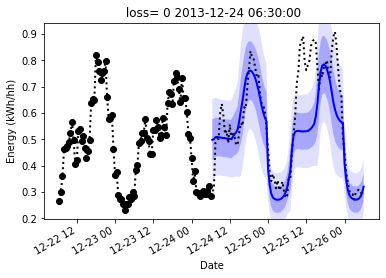

step 16442, {'val_loss': '-0.20476043224334717', 'val/loss_mse': '0.0073477840051054955', 'val/loss_p': '-0.20476043224334717', 'val/sigma': '0.05184084549546242'}


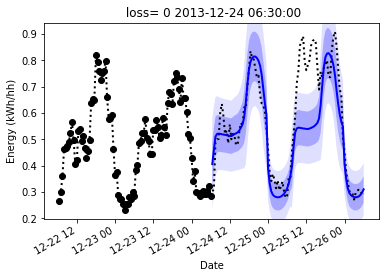

step 18269, {'val_loss': '-0.22172309458255768', 'val/loss_mse': '0.006462480407208204', 'val/loss_p': '-0.22172309458255768', 'val/sigma': '0.04278193414211273'}
Epoch     9: reducing learning rate of group 0 to 1.0000e-04.


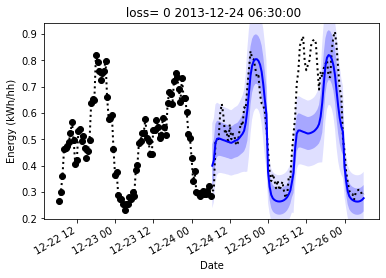

step 20096, {'val_loss': '-0.22574861347675323', 'val/loss_mse': '0.005879856646060944', 'val/loss_p': '-0.22574861347675323', 'val/sigma': '0.03965809941291809'}


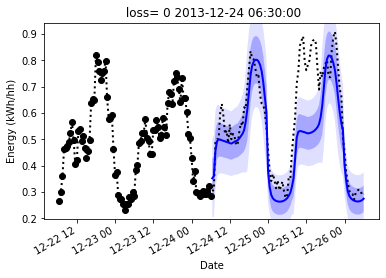

step 21923, {'val_loss': '-0.22455187141895294', 'val/loss_mse': '0.005973877850919962', 'val/loss_p': '-0.22455187141895294', 'val/sigma': '0.038804806768894196'}


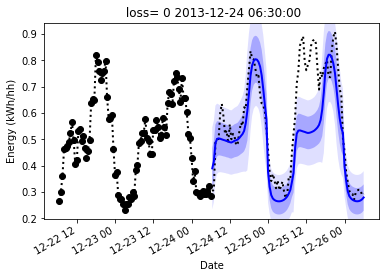

step 23750, {'val_loss': '-0.22228951752185822', 'val/loss_mse': '0.006035246886312962', 'val/loss_p': '-0.22228951752185822', 'val/sigma': '0.03811655566096306'}


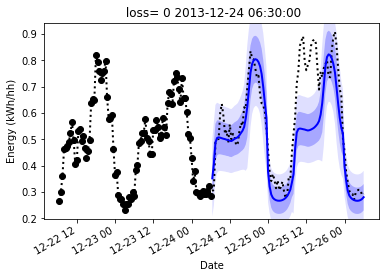

step 25577, {'val_loss': '-0.2273477166891098', 'val/loss_mse': '0.005770019255578518', 'val/loss_p': '-0.2273477166891098', 'val/sigma': '0.03672665357589722'}


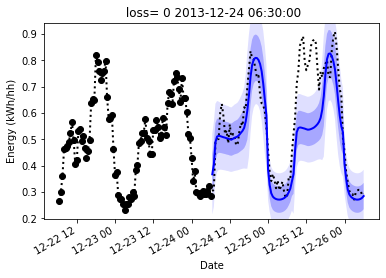

step 27404, {'val_loss': '-0.22601139545440674', 'val/loss_mse': '0.006057026330381632', 'val/loss_p': '-0.22601139545440674', 'val/sigma': '0.03654864802956581'}


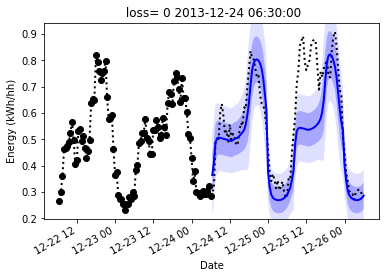

step 29231, {'val_loss': '-0.22229242324829102', 'val/loss_mse': '0.006490075960755348', 'val/loss_p': '-0.22229242324829102', 'val/sigma': '0.03702005743980408'}


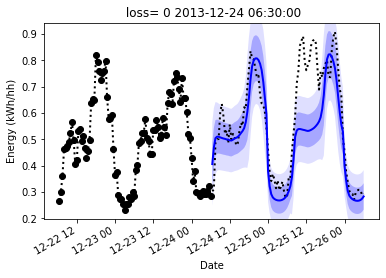

step 31058, {'val_loss': '-0.2225848287343979', 'val/loss_mse': '0.00630600331351161', 'val/loss_p': '-0.2225848287343979', 'val/sigma': '0.03496050089597702'}
Epoch    16: reducing learning rate of group 0 to 1.0000e-05.


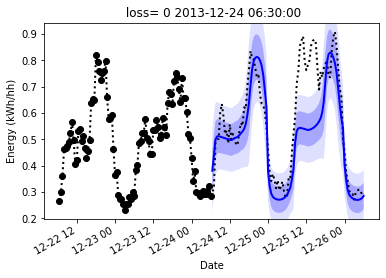

step 32885, {'val_loss': '-0.21894674003124237', 'val/loss_mse': '0.0068154968321323395', 'val/loss_p': '-0.21894674003124237', 'val/sigma': '0.034927889704704285'}
INFO:root:Epoch 00018: early stopping



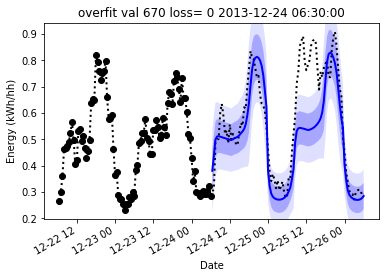

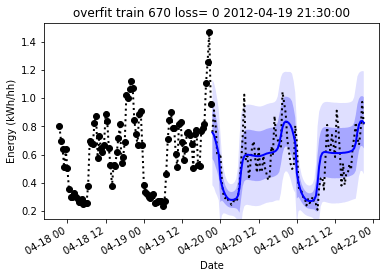

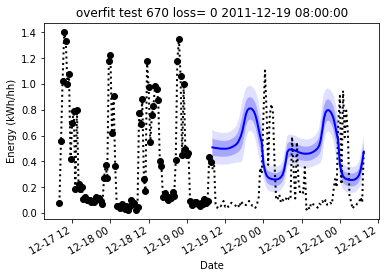

Loading checkpoint lightning_logs/LSTM_PL_STD/version_-11/_ckpt_epoch_13.ckpt


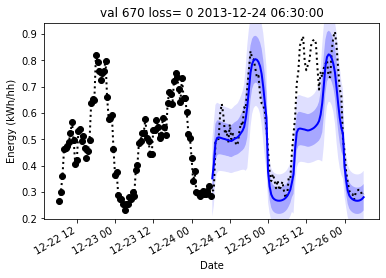

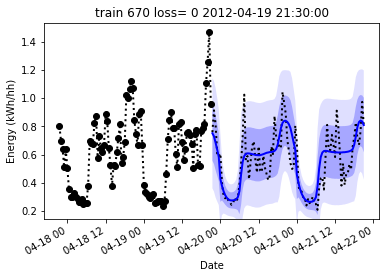

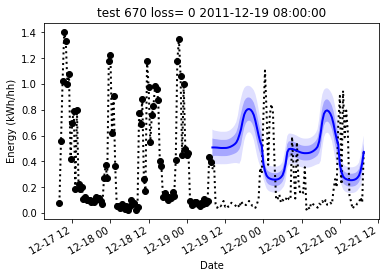

INFO:predict_heading2:step 32886, {'test_loss_p': '2.4851086139678955', 'test_loss_mse': '0.15460515022277832'}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



In [23]:
trial, trainer, model = run_trial(name="LSTM_PL_STD",
                                  params={},
                                  user_attrs=default_user_attrs,
                                  PL_MODEL_CLS=LSTM_PL_STD)

In [24]:
name = trainer.logger.name
results[f"{name}_{trial.number}"]=dict(
    **trainer.logger.metrics[-1],
    **(trainer.logger.metrics[-2] if len(trainer.logger.metrics)>1 else {})
)
results[f"{name}_{trial.number}"]

{'test_loss_p': 2.4851086139678955,
 'test_loss_mse': 0.15460515022277832,
 'val_loss': -0.21894674003124237,
 'val/loss_mse': 0.0068154968321323395,
 'val/loss_p': -0.21894674003124237,
 'val/sigma': 0.034927889704704285}

## LSTM seq2seq

now run `tensorboard --logdir lightning_logs`
trial.number -8
trial -8 <optuna.trial.FixedTrial object at 0x7f3ee8747160> {'learning_rate': 0.001, 'lstm_dropout': 0.22, 'hidden_size_power': 4.0, 'lstm_layers': 4, 'bidirectional': False} {'batch_size': 16, 'grad_clip': 40, 'max_nb_epochs': 200, 'num_workers': 3, 'num_extra_target': 96, 'vis_i': '670', 'num_context': 96, 'input_size': 18, 'input_size_decoder': 17, 'context_in_target': False, 'output_size': 1, 'min_std': 0.005, 'x_dim': 17, 'y_dim': 1, 'patience': 2}
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
   | Name                           | Type               | Params
------------------------------------------------------------------
0  | _model                         | Seq2SeqNet         | 18 K  
1  | _model.norm_input              | BatchNormSequence  | 36    
2  | _model.norm_input.norm         | BatchNorm1d        | 36    
3  | _model.encoder                 | LSTM               | 8 K   
4  |

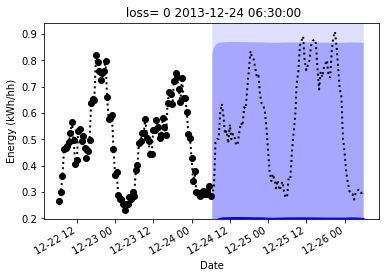

step 0, {'val_loss': '0.6567961573600769', 'val/loss_mse': '0.12635520100593567', 'val/loss_p': '0.6567961573600769', 'val/sigma': '0.9160766005516052'}


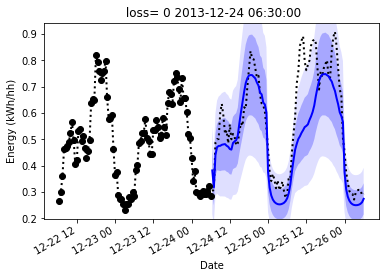

step 1826, {'val_loss': '-0.9680321216583252', 'val/loss_mse': '0.009241494350135326', 'val/loss_p': '-0.9680321216583252', 'val/sigma': '0.06401461362838745'}


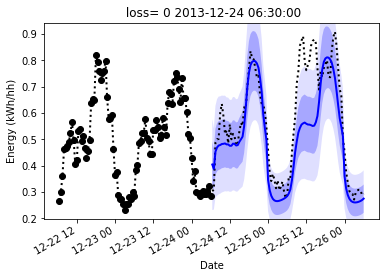

step 3653, {'val_loss': '-1.1127718687057495', 'val/loss_mse': '0.0069497269578278065', 'val/loss_p': '-1.1127718687057495', 'val/sigma': '0.044856809079647064'}


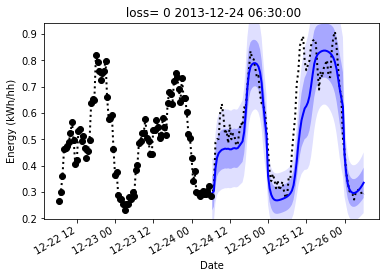

step 5480, {'val_loss': '-1.274307131767273', 'val/loss_mse': '0.004984005354344845', 'val/loss_p': '-1.274307131767273', 'val/sigma': '0.03452633321285248'}


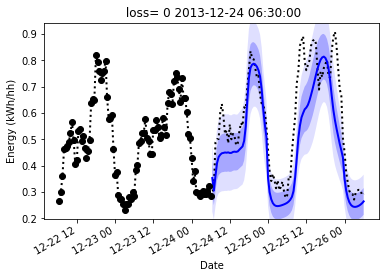

step 7307, {'val_loss': '-1.2190721035003662', 'val/loss_mse': '0.005428652744740248', 'val/loss_p': '-1.2190721035003662', 'val/sigma': '0.02654687874019146'}


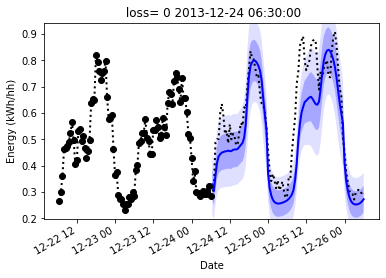

step 9134, {'val_loss': '-1.3281409740447998', 'val/loss_mse': '0.004450082778930664', 'val/loss_p': '-1.3281409740447998', 'val/sigma': '0.023709537461400032'}


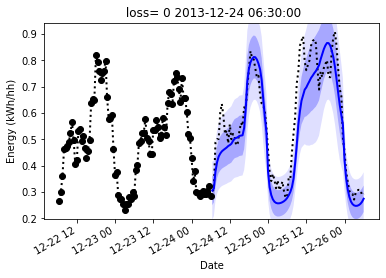

step 10961, {'val_loss': '-1.3111597299575806', 'val/loss_mse': '0.004637664649635553', 'val/loss_p': '-1.3111597299575806', 'val/sigma': '0.025528842583298683'}


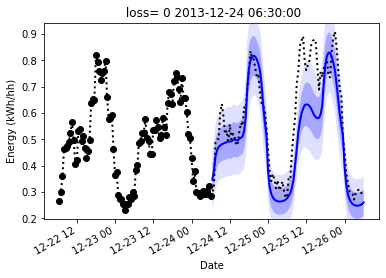

step 12788, {'val_loss': '-1.2543833255767822', 'val/loss_mse': '0.005186781287193298', 'val/loss_p': '-1.2543833255767822', 'val/sigma': '0.021399999037384987'}


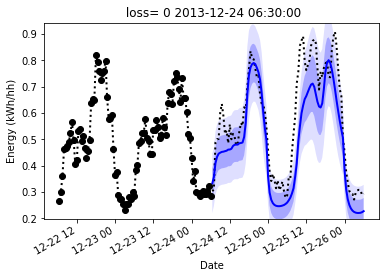

step 14615, {'val_loss': '-1.2503859996795654', 'val/loss_mse': '0.005117818713188171', 'val/loss_p': '-1.2503859996795654', 'val/sigma': '0.01906217634677887'}
Epoch     7: reducing learning rate of group 0 to 1.0000e-04.


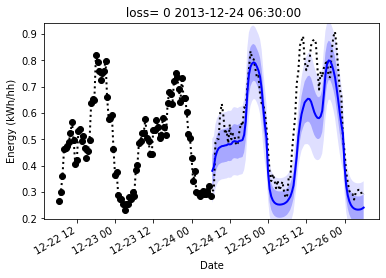

step 16442, {'val_loss': '-1.2827746868133545', 'val/loss_mse': '0.0049745202995836735', 'val/loss_p': '-1.2827746868133545', 'val/sigma': '0.01666550152003765'}
INFO:root:Epoch 00009: early stopping



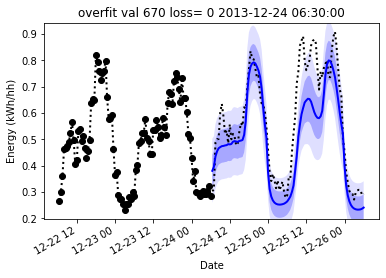

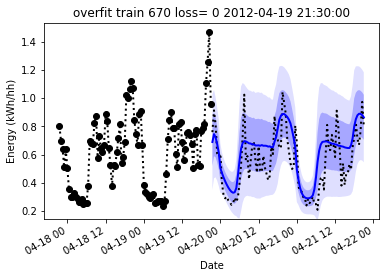

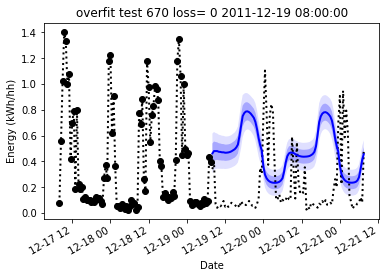

Loading checkpoint lightning_logs/LSTMSeq2Seq_PL/version_-8/_ckpt_epoch_4.ckpt


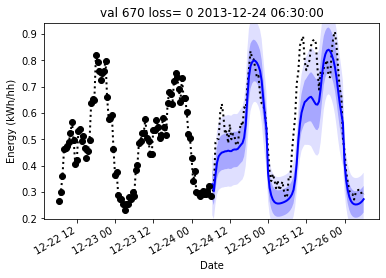

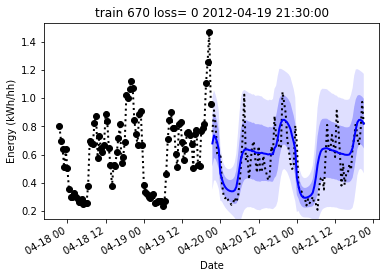

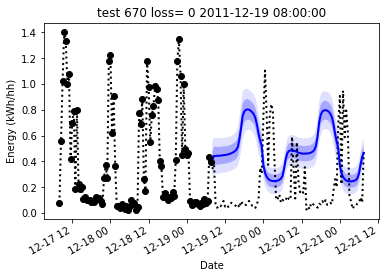

INFO:predict_heading2:step 16443, {'test_loss_p': '15.472498893737793', 'test_loss_mse': '0.17234423756599426'}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------



In [25]:
trial, trainer, model = run_trial(name="LSTMSeq2Seq_PL",
                                  params={},
                                  user_attrs=default_user_attrs,
                                  PL_MODEL_CLS=LSTMSeq2Seq_PL)

In [26]:
name = trainer.logger.name
results[f"{name}_{trial.number}"]=dict(
    **trainer.logger.metrics[-1],
    **(trainer.logger.metrics[-2] if len(trainer.logger.metrics)>1 else {})
)
results[f"{name}_{trial.number}"]

{'test_loss_p': 15.472498893737793,
 'test_loss_mse': 0.17234423756599426,
 'val_loss': -1.2827746868133545,
 'val/loss_mse': 0.0049745202995836735,
 'val/loss_p': -1.2827746868133545,
 'val/sigma': 0.01666550152003765}

# Hyperparam

In [27]:
import argparse 

parser = argparse.ArgumentParser(description='PyTorch Lightning example.')
parser.add_argument('--pruning', '-p', action='store_true',
                    help='Activate the pruning feature. `MedianPruner` stops unpromising '
                         'trials at the early stages of training.')
args = parser.parse_args(['-p'])

pruner = optuna.pruners.MedianPruner(n_warmup_steps=1, n_startup_trials=20) if args.pruning else optuna.pruners.NopPruner()
pruner = optuna.pruners.PercentilePruner(75.0)
name = 'anp-rnn1'
study = optuna.create_study(direction='minimize', pruner=pruner, storage=f'sqlite:///optuna_result/{name}.db', study_name=name, load_if_exists=True)


[I 2020-04-12 13:06:55,277] Using an existing study with name 'anp-rnn1' instead of creating a new one.


In [28]:
study.optimize(objective, n_trials=200, timeout=pd.Timedelta('3d').total_seconds())

[W 2020-04-12 13:06:55,525] Setting status of trial#2 as TrialState.FAIL because of the following error: TypeError("objective() missing 1 required positional argument: 'PL_MODEL_CLS'")
Traceback (most recent call last):
  File "/home/wassname/.pyenv/versions/jup3.7.3/lib/python3.7/site-packages/optuna/study.py", line 569, in _run_trial
    result = func(trial)
TypeError: objective() missing 1 required positional argument: 'PL_MODEL_CLS'


TypeError: objective() missing 1 required positional argument: 'PL_MODEL_CLS'

In [ ]:

print('Number of finished trials: {}'.format(len(study.trials)))

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

# shutil.rmtree(MODEL_DIR)

## View

TODO

In [ ]:
df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
df.sort_values('value')

In [ ]:
df.sort_values('value').head(17).T